Evaluating the anomaly detection method based on (averaged) localized p-value estimation (aK-LPE) proposed in [1] and [2].

1. K-LPE method:  
Zhao, Manqi, and Venkatesh Saligrama. "Anomaly detection with score functions based on nearest neighbor graphs."
Advances in neural information processing systems. 2009.

1. Averaged K-LPE method:  
Qian, Jing, and Venkatesh Saligrama. "New statistic in p-value estimation for anomaly detection."
IEEE Statistical Signal Processing Workshop (SSP). IEEE, 2012.

In [1]:
import numpy as np
from multiprocessing import cpu_count
from generate_data import MFA_model
from localized_pvalue_estimation import averaged_KLPE_anomaly_detection
from sklearn.metrics import (
    roc_curve,
    roc_auc_score, 
    average_precision_score, 
    precision_recall_curve
)
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# A wrapper function to generate training and test data for anomaly detection
def wrapper_data_generate(dim, dim_latent_range, n_components, N_train, N_test, 
                          prop_anomaly=0.1, anom_type='uniform', seed_rng=123):
    # Generate data according to a mixture of factor analysis (MFA) model
    model = MFA_model(n_components, dim, dim_latent_range=dim_latent_range, seed_rng=seed_rng)

    # Generate nominal data from the MFA model
    data, _ = model.generate_data(N_train)

    # Generate a mixture of nominal and anomalous data as the test set
    N_test_anom = int(np.ceil(prop_anomaly * N_test))
    N_test_nom = N_test - N_test_anom
    data_nom, _ = model.generate_data(N_test_nom)

    # Anomalous points are generated either from a uniform distribution or a Gaussian distribution
    x_min = np.min(data, axis=0)
    x_max = np.max(data, axis=0)
    x_mean = np.mean(data, axis=0)
    x_std = np.std(data, axis=0)
    
    data_anom = np.zeros((N_test_anom, dim))
    for i in range(dim):
        if anom_type == 'uniform':
            data_anom[:, i] = np.random.uniform(low=x_min[i], high=x_max[i], size=N_test_anom)
        else:
            # Gaussian
            data_anom[:, i] = np.random.normal(loc=x_mean[i], scale=x_std[i], size=N_test_anom)

    data_test = np.concatenate([data_nom, data_anom], axis=0)
    labels_test = np.concatenate([np.zeros(N_test_nom, dtype=np.int), 
                                  np.ones(N_test_anom, dtype=np.int)])
    
    return data, data_test, labels_test


In [3]:
# Wrapper function that calculates a bunch of performance metrics
def metrics_detection(scores, labels, pos_label=1, max_fpr=0.01, verbose=True):
    au_roc = roc_auc_score(labels, scores)
    au_roc_partial = roc_auc_score(labels, scores, max_fpr=max_fpr)
    avg_prec = average_precision_score(labels, scores)
    
    if verbose:
        print("Area under the ROC curve = {:.6f}".format(au_roc))
        print("Partial area under the ROC curve below FPR of {:.2f} = {:.6f}".format(max_fpr, au_roc_partial))
        print("Average precision = {:.6f}".format(avg_prec))
    
    # ROC curve and TPR at a few low FPR values
    fpr_arr, tpr_arr, thresh = roc_curve(labels, scores, pos_label=pos_label)
    fpr_thresh = [0.001, 0.005, 0.01, 0.05, 0.1]
    tpr = np.zeros(len(fpr_thresh))
    fpr = np.zeros_like(tpr)
    if verbose:
        print("\nTPR, FPR")
    
    for i, a in enumerate(fpr_thresh):
        mask = fpr_arr >= a
        tpr[i] = tpr_arr[mask][0]
        fpr[i] = fpr_arr[mask][0]
        if verbose:
            print("{:.6f}, {:.6f}".format(tpr[i], fpr[i]))
        
    return au_roc, au_roc_partial, avg_prec, tpr, fpr
    

In [4]:
# Define some constants
n_jobs = max(cpu_count() - 2, 1)
seed_rng = np.random.randint(1, high=10000)
metric_primary = 'euclidean'
shared_nearest_neighbors = False

# Neighborhood size is chosen as a function of the number of data points. 
# In [1], it is recommended to chose `k = n^{2 / 5} = n^0.4`
neighborhood_constant = 0.4

max_fpr_pauc = 0.01

In [5]:
# Generate data according to a mixture of factor analysis (MFA) model
np.random.seed(seed_rng)

# number of mixture components
n_components = 10
# dimension of the observed space
dim = 100
# Specify a range for the latent dimension
dim_latent_range = (10, 20)

# Number of training points, test points, and proportion of anomalies in the test data
N = 5000
N_test = 1000
prop_anomaly = 0.1

data, data_test, labels_test = wrapper_data_generate(dim, dim_latent_range, n_components, 
                                                     N, N_test, prop_anomaly=prop_anomaly, 
                                                     anom_type='gaussian', seed_rng=seed_rng)

In [6]:
# Initialize the anomaly detection (AD) model
detector = averaged_KLPE_anomaly_detection(
    neighborhood_constant=neighborhood_constant, 
    n_neighbors=None, 
    metric=metric_primary, 
    metric_kwargs=None,
    shared_nearest_neighbors=shared_nearest_neighbors, 
    approx_nearest_neighbors=True,
    n_jobs=n_jobs, 
    seed_rng=seed_rng
)

# Fit the AD model to the nominal training data
detector.fit(data)

# Calculate the anomaly score of the test data
scores_test = detector.score(data_test)

In [7]:
# Calculate some performance metrics
au_roc, au_roc_partial, avg_prec, tpr_spec, fpr_spec = metrics_detection(
    scores_test, labels_test, pos_label=1, max_fpr=max_fpr_pauc, verbose=True
)

Area under the ROC curve = 0.998150
Partial area under the ROC curve below FPR of 0.01 = 0.907035
Average precision = 0.962243

TPR, FPR
0.060000, 0.001111
0.940000, 0.006667
1.000000, 0.016667
1.000000, 0.053333
1.000000, 0.101111


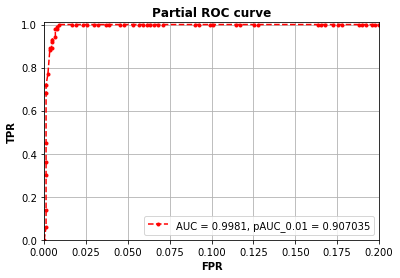

In [8]:
# ROC curve
fpr_arr, tpr_arr, thresh = roc_curve(labels_test, scores_test, pos_label=1)

fig = plt.figure()
ls = "AUC = {:.4f}, pAUC_{:.2f} = {:.6f}".format(au_roc, max_fpr_pauc, au_roc_partial)
plt.plot(fpr_arr, tpr_arr, linestyle='--', color='r', marker='.', label=ls)
plt.xlabel('FPR', fontweight='bold')
plt.ylabel('TPR', fontweight='bold')
plt.xlim([0.0, 0.2])
plt.ylim([0.0, 1.01])
plt.title('Partial ROC curve', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

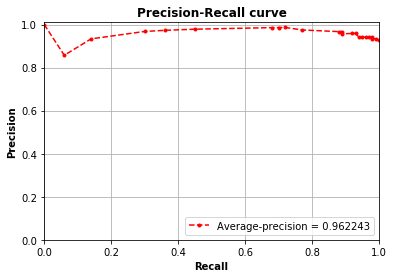

In [9]:
# Precision-Recall curve
precision_arr, recall_arr, _ = precision_recall_curve(labels_test, scores_test, pos_label=1)

fig = plt.figure()
ls = "Average-precision = {:.6f}".format(avg_prec)
plt.plot(recall_arr, precision_arr, linestyle='--', color='r', marker='.', label=ls)
plt.xlabel('Recall', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Precision-Recall curve', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()